In [1]:
!pip install awswrangler

In [1]:
import pandas as pd
import seaborn as sns
import pandas as pd
import numpy as np
from datetime import date
from sqlalchemy import create_engine
import os
import boto3
import awswrangler as wr
import matplotlib.pyplot as plt

In [3]:
staging_path = 's3://will-prod-ml-platform-sagemaker-studio/staging/flavia-costa/'
boto3_session = boto3.Session(region_name='sa-east-1')

In [4]:
query = """

select 
date_trunc('month', ult_disparo_email) as mes_envio_email --ultimo mes
, date_trunc('month',  ult_disparo_push) as mes_envio_push
, date_trunc('month',  ult_disparo_sms) as mes_envio_sms
, count(distinct cpf) as clientes
from martech_curated_zone.historico_acionamento_pmm_cliente
group by 1,2,3


"""

In [5]:
# Clean temporary folder
wr.s3.delete_objects(staging_path, boto3_session=boto3_session)

# Run query
print('Started query')

df = wr.athena.read_sql_query(
    sql=query,
    database=None,
    unload_approach=True,
    ctas_approach=False,
    boto3_session=boto3_session,
    s3_output=staging_path
)
wr.s3.delete_objects(staging_path, boto3_session=boto3_session)

Started query


In [7]:
df.head()

,mes_envio_email,mes_envio_push,mes_envio_sms,clientes
0,2023-08-01,2023-06-01,2023-07-01,10403
1,2023-07-01,2023-07-01,None,178726
2,2023-03-01,2023-02-01,2023-03-01,10347
3,2023-07-01,2023-01-01,2023-03-01,299
4,2023-04-01,2023-08-01,2023-04-01,407


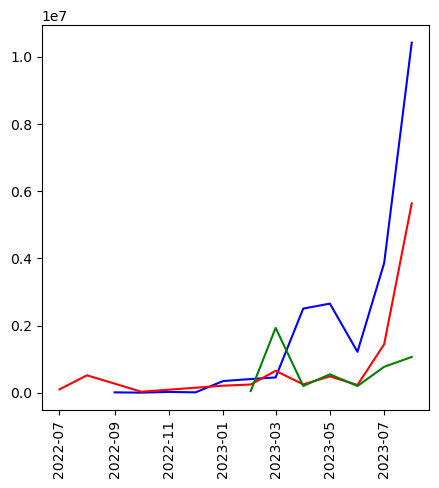

In [49]:
plt.figure(figsize = (5,5))
plt.plot(df.groupby('mes_envio_email').agg({'clientes':['sum']}), color = 'blue')
plt.plot(df.groupby('mes_envio_push').agg({'clientes':['sum']}), color = 'red')
plt.plot(df.groupby('mes_envio_sms').agg({'clientes':['sum']}), color = 'green')
plt.xticks(rotation=90)
plt.show()

In [50]:

query = """

select 
interacao_email
, interacao_push
, count(distinct cpf) as clientes
from martech_curated_zone.historico_acionamento_pmm_cliente
group by 1,2


"""


wr.s3.delete_objects(staging_path, boto3_session=boto3_session)

# Run query
print('Started query')

df2 = wr.athena.read_sql_query(
    sql=query,
    database=None,
    unload_approach=True,
    ctas_approach=False,
    boto3_session=boto3_session,
    s3_output=staging_path
)
wr.s3.delete_objects(staging_path, boto3_session=boto3_session)

Started query


<AxesSubplot:xlabel='clientes', ylabel='interacao_email'>

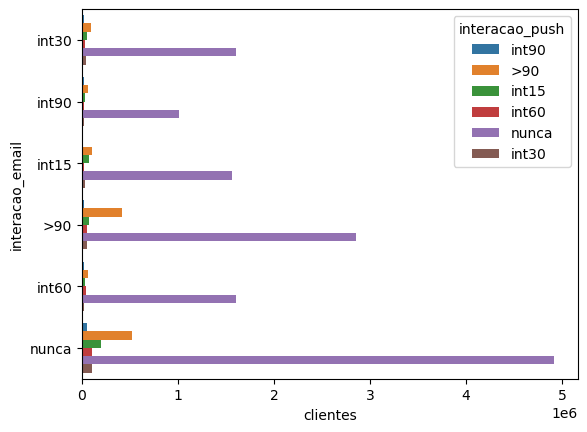

In [69]:
sns.barplot(data = df2, y = 'interacao_email', x = 'clientes', hue = 'interacao_push')

In [65]:
df2.sort_values(by = 'clientes', ascending = False).head(10)

,interacao_email,interacao_push,clientes
14,nunca,nunca,4919542
17,>90,nunca,2856178
33,int60,nunca,1602711
7,int30,nunca,1599580
26,int15,nunca,1566894
34,int90,nunca,1007963
18,nunca,>90,524602
9,>90,>90,421435
27,nunca,int15,195789
20,int15,>90,102343


In [2]:
query = """

select 
c.cpf
, max(p.ds_cluster_sociodemographic) as persona
, max(case when interacao_email <> 'nunca' then 1 else 0 end) as flag_email
, max(case when interacao_push <> 'nunca' then 1 else 0 end) as flag_push
from martech_curated_zone.historico_acionamento_pmm_cliente c
left join customer_curated_zone.ca_book_cliente cli on (cli.cpf = c.cpf)
left join customer_curated_zone.ca_book_cliente_cluster p on (p.id_customer = cli.id_customer) 
where (ult_disparo_email is not null or ult_disparo_push is not null)
and (interacao_email <> 'nunca' or interacao_push <> 'nunca')
group by 1
order by rand()
limit 500000


"""

# wr.s3.delete_objects(staging_path, boto3_session=boto3_session)

# # Run query
# print('Started query')

# df3 = wr.athena.read_sql_query(
#     sql=query,
#     database=None,
#     unload_approach=True,
#     ctas_approach=False,
#     boto3_session=boto3_session,
#     s3_output=staging_path 
# )
# wr.s3.delete_objects(staging_path, boto3_session=boto3_session)

from acessos import df_athena_q

df3 = df_athena_q('flavia-costa', query)


In [3]:
len(df3)

500000

In [6]:
df3

,cpf,persona,flag_email,flag_push,segmento
0,16339164803,"0 - Mulher, Casada, 25 anos ou mais, cidade Pe...",1,0,2 - Apenas Email
1,07852488382,"22 - Mulher, Até 24 anos, Nordeste",1,0,2 - Apenas Email
2,84180439115,"32 - Homem, 41 anos ou mais, Centro-Oeste e Norte",1,0,2 - Apenas Email
3,05748628627,"25 - Homem, 41 anos ou mais, Sudeste e Sul",1,0,2 - Apenas Email
4,03056209242,"27 - Homem, 25 a 40 anos, Centro-Oeste e Norte",1,0,2 - Apenas Email
...,...,...,...,...,...
499995,84371854915,"21 - Mulher, 41 anos ou mais, Sudeste e Sul",1,0,2 - Apenas Email
499996,17482324607,"8 - Mulher, Solteira, Até 24 anos, cidade Pequ...",1,1,1 - Engajado em dois canais
499997,08068582576,"22 - Mulher, Até 24 anos, Nordeste",1,1,1 - Engajado em dois canais
499998,00751917508,"19 - Mulher, 41 anos ou mais, Nordeste",0,1,3 - Apenas Push


In [4]:
df3['segmento'] = np.where((df3['flag_email'] == 1) & (df3['flag_push'] == 1), "1 - Engajado em dois canais", 
                    np.where((df3['flag_email'] == 1) & (df3['flag_push'] == 0), "2 - Apenas Email",
                          np.where((df3['flag_email'] == 0) & (df3['flag_push'] == 1), "3 - Apenas Push", "NI")))


df3['segmento'].value_counts()

2 - Apenas Email               327251
1 - Engajado em dois canais    158018
3 - Apenas Push                 14731
Name: segmento, dtype: int64

In [5]:
df3['segmento'].value_counts(normalize = True)

2 - Apenas Email               0.654502
1 - Engajado em dois canais    0.316036
3 - Apenas Push                0.029462
Name: segmento, dtype: float64

In [7]:
for i in df3.persona.unique():
    print(i)
    print(df3[df3['persona'] == i]['segmento'].value_counts(normalize = True))

0 - Mulher, Casada, 25 anos ou mais, cidade Pequena do Nordeste
2 - Apenas Email               0.575499
1 - Engajado em dois canais    0.382996
3 - Apenas Push                0.041505
Name: segmento, dtype: float64
22 - Mulher, Até 24 anos, Nordeste
2 - Apenas Email               0.715413
1 - Engajado em dois canais    0.268804
3 - Apenas Push                0.015783
Name: segmento, dtype: float64
32 - Homem, 41 anos ou mais, Centro-Oeste e Norte
2 - Apenas Email               0.601010
1 - Engajado em dois canais    0.368687
3 - Apenas Push                0.030303
Name: segmento, dtype: float64
25 - Homem, 41 anos ou mais, Sudeste e Sul
2 - Apenas Email               0.643628
1 - Engajado em dois canais    0.328836
3 - Apenas Push                0.027536
Name: segmento, dtype: float64
27 - Homem, 25 a 40 anos, Centro-Oeste e Norte
2 - Apenas Email               0.629421
1 - Engajado em dois canais    0.343337
3 - Apenas Push                0.027242
Name: segmento, dtype: float64
18 - H

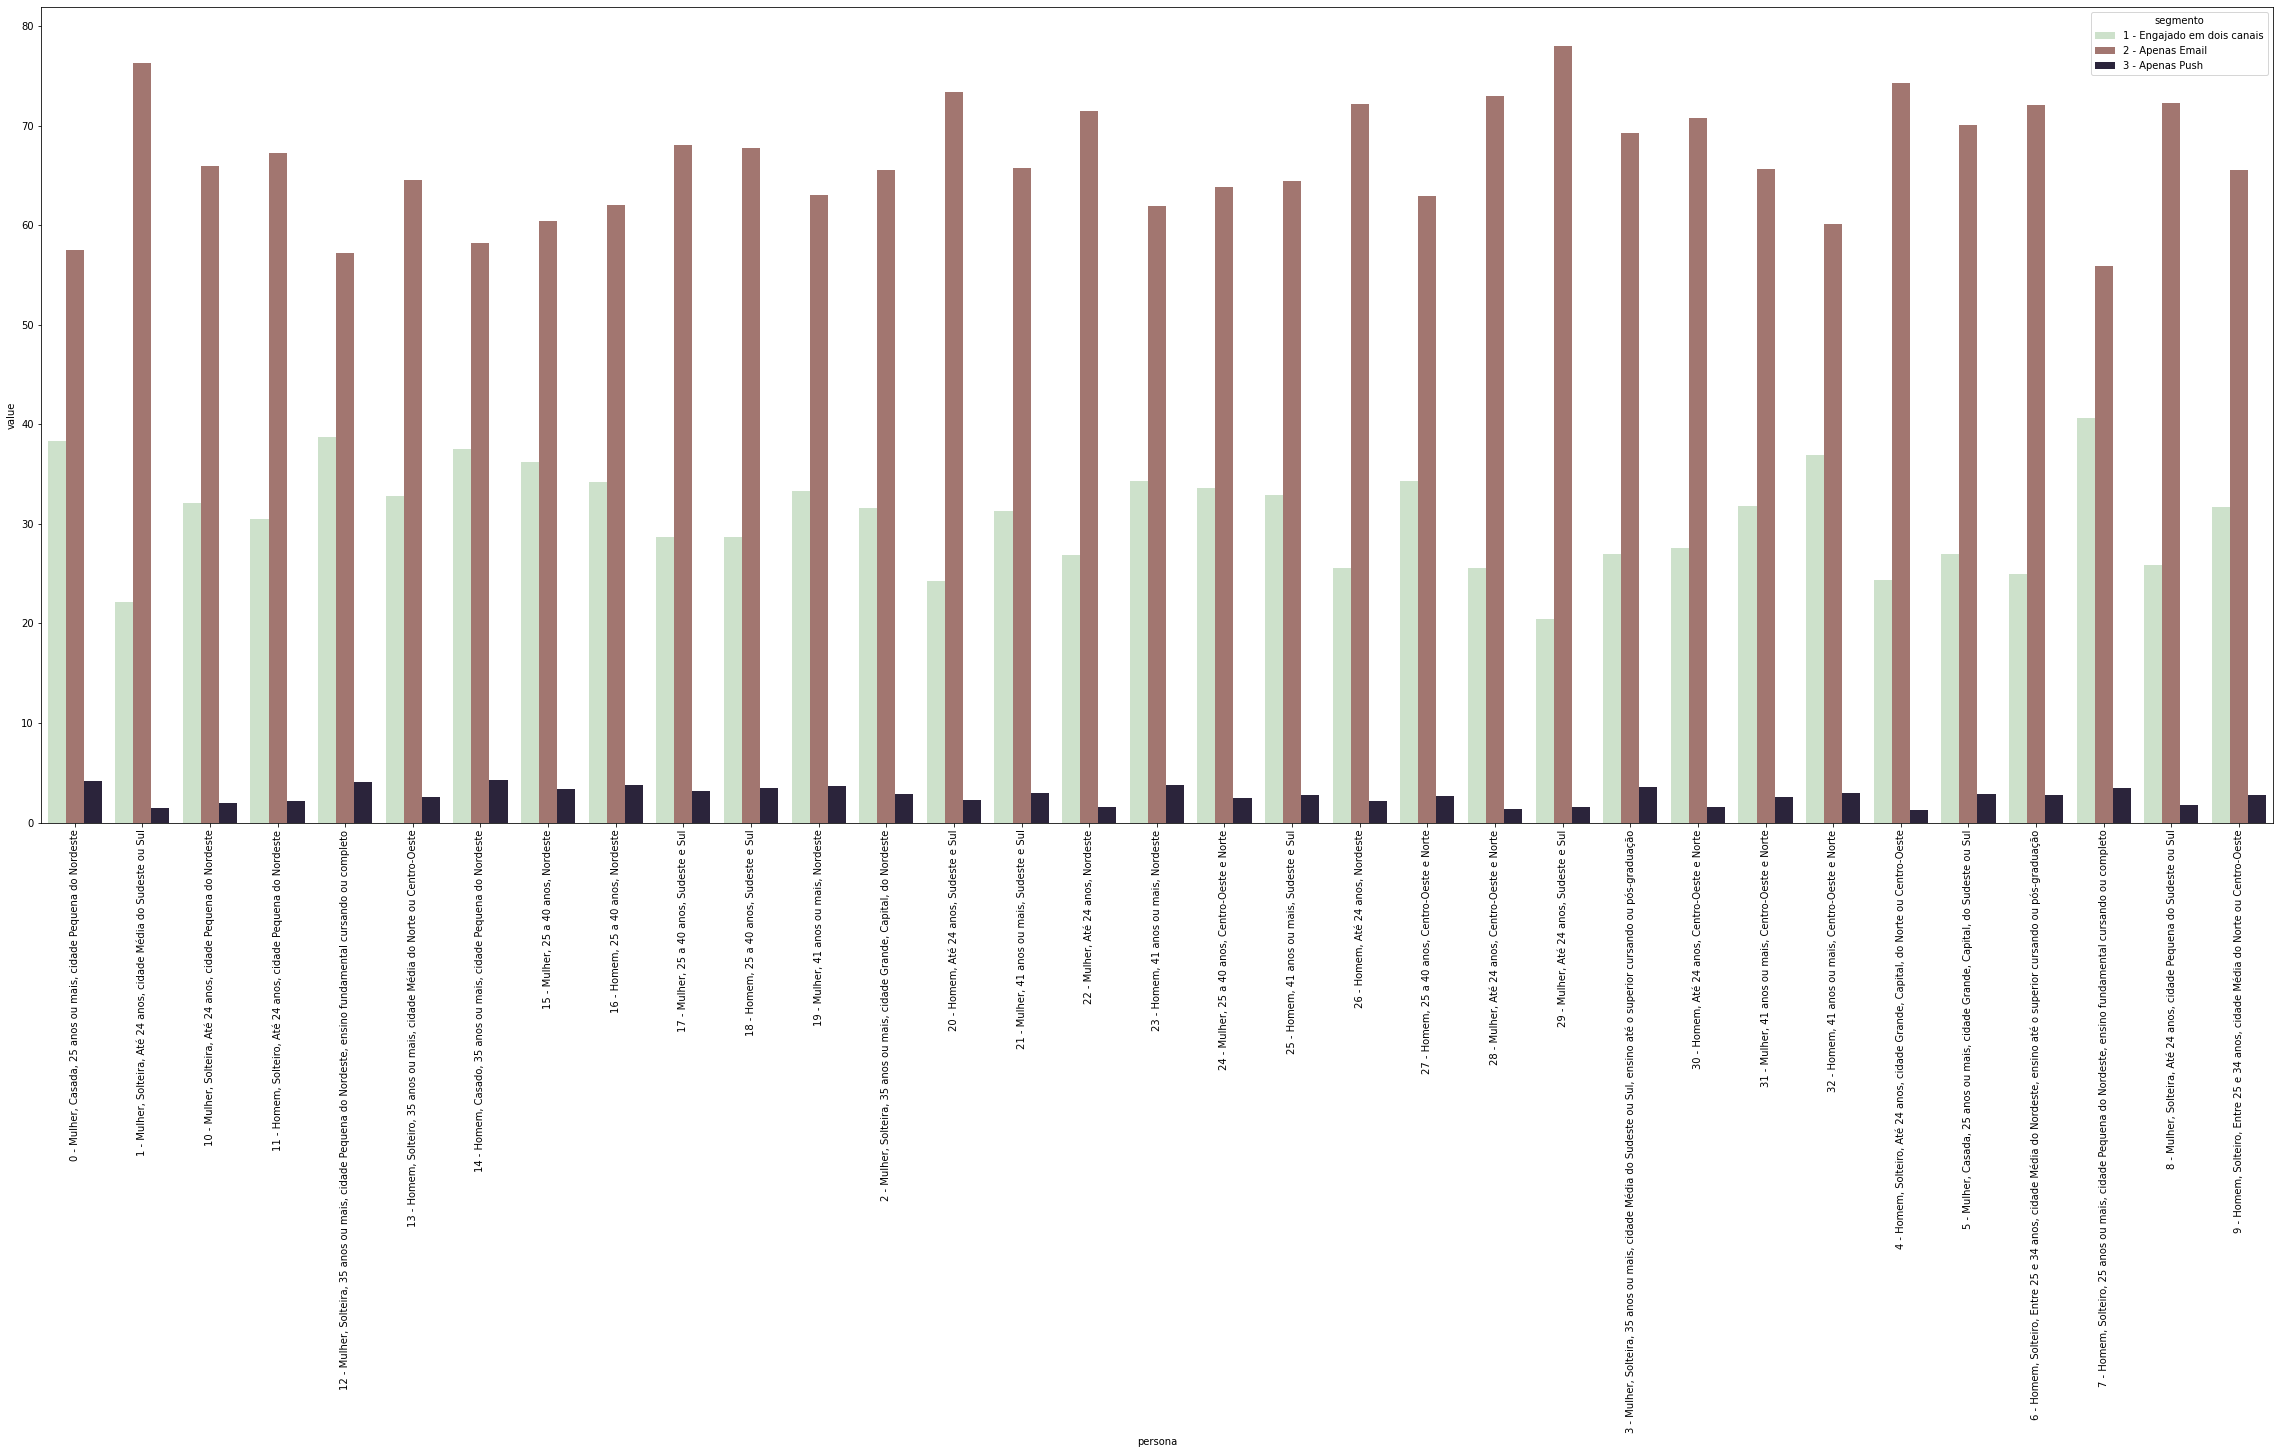

In [16]:
vars_agregacao = ['persona'] #vão estar no x. Precisam ser categóricas

for i in vars_agregacao:
    group_var = 'segmento' #vai estar na legenda
    x_var = i
    campo_contagem = 'count'
    agg = df3.groupby([i, group_var]).agg({'cpf':['count']}) #alterar nome do dataframe e variavel de contagem
    agg.columns = agg.columns.droplevel(0)
    agg = agg.reset_index()
    df_viz = agg.pivot_table(columns=x_var,index = group_var, values=campo_contagem, aggfunc=np.sum)

    for i in df_viz.columns:
        df_viz[i] = df_viz[i] / df_viz[i].sum()

    df_viz = df_viz.reset_index()
    df_viz = pd.melt(df_viz, id_vars=[group_var])
    df_viz['value'] = df_viz['value'] * 100
    x = df_viz[x_var].astype('str')
    y = df_viz[group_var].astype('str')
    z = df_viz.value.round(1)
    plt.figure(figsize = (40,15))
    sns.barplot(data = df_viz, x = x, y = z, hue = y, palette="ch:s=1,rot=-2")
    plt.xticks(rotation=90)
    plt.show()

In [9]:
df_viz.query('segmento == "2 - Apenas Email"').sort_values(by = 'value', ascending=False).head(10)

,segmento,persona,value
67,2 - Apenas Email,"29 - Mulher, Até 24 anos, Sudeste e Sul",77.974948
4,2 - Apenas Email,"1 - Mulher, Solteira, Até 24 anos, cidade Médi...",76.279540
82,2 - Apenas Email,"4 - Homem, Solteiro, Até 24 anos, cidade Grand...",74.281392
40,2 - Apenas Email,"20 - Homem, Até 24 anos, Sudeste e Sul",73.416974
64,2 - Apenas Email,"28 - Mulher, Até 24 anos, Centro-Oeste e Norte",72.978031
94,2 - Apenas Email,"8 - Mulher, Solteira, Até 24 anos, cidade Pequ...",72.315467
58,2 - Apenas Email,"26 - Homem, Até 24 anos, Nordeste",72.215552
88,2 - Apenas Email,"6 - Homem, Solteiro, Entre 25 e 34 anos, cidad...",72.142411
46,2 - Apenas Email,"22 - Mulher, Até 24 anos, Nordeste",71.541306
73,2 - Apenas Email,"30 - Homem, Até 24 anos, Centro-Oeste e Norte",70.767770


In [10]:
df_viz.query('segmento == "2 - Apenas Email"').sort_values(by = 'value', ascending=True).head(10)

,segmento,persona,value
91,2 - Apenas Email,"7 - Homem, Solteiro, 25 anos ou mais, cidade P...",55.876866
13,2 - Apenas Email,"12 - Mulher, Solteira, 35 anos ou mais, cidade...",57.228261
1,2 - Apenas Email,"0 - Mulher, Casada, 25 anos ou mais, cidade Pe...",57.549872
19,2 - Apenas Email,"14 - Homem, Casado, 35 anos ou mais, cidade Pe...",58.174191
79,2 - Apenas Email,"32 - Homem, 41 anos ou mais, Centro-Oeste e Norte",60.101010
22,2 - Apenas Email,"15 - Mulher, 25 a 40 anos, Nordeste",60.364999
49,2 - Apenas Email,"23 - Homem, 41 anos ou mais, Nordeste",61.918347
25,2 - Apenas Email,"16 - Homem, 25 a 40 anos, Nordeste",62.047202
61,2 - Apenas Email,"27 - Homem, 25 a 40 anos, Centro-Oeste e Norte",62.942143
34,2 - Apenas Email,"19 - Mulher, 41 anos ou mais, Nordeste",63.024881


In [11]:
df_viz.query('segmento == "3 - Apenas Push"').sort_values(by = 'value', ascending=False).head(10)

,segmento,persona,value
20,3 - Apenas Push,"14 - Homem, Casado, 35 anos ou mais, cidade Pe...",4.338227
2,3 - Apenas Push,"0 - Mulher, Casada, 25 anos ou mais, cidade Pe...",4.150545
14,3 - Apenas Push,"12 - Mulher, Solteira, 35 anos ou mais, cidade...",4.076087
50,3 - Apenas Push,"23 - Homem, 41 anos ou mais, Nordeste",3.778369
26,3 - Apenas Push,"16 - Homem, 25 a 40 anos, Nordeste",3.768348
35,3 - Apenas Push,"19 - Mulher, 41 anos ou mais, Nordeste",3.724886
71,3 - Apenas Push,"3 - Mulher, Solteira, 35 anos ou mais, cidade ...",3.641882
92,3 - Apenas Push,"7 - Homem, Solteiro, 25 anos ou mais, cidade P...",3.492952
32,3 - Apenas Push,"18 - Homem, 25 a 40 anos, Sudeste e Sul",3.491591
23,3 - Apenas Push,"15 - Mulher, 25 a 40 anos, Nordeste",3.406543


In [12]:
df_viz.query('segmento == "3 - Apenas Push"').sort_values(by = 'value', ascending=True).head(10)

,segmento,persona,value
83,3 - Apenas Push,"4 - Homem, Solteiro, Até 24 anos, cidade Grand...",1.311145
65,3 - Apenas Push,"28 - Mulher, Até 24 anos, Centro-Oeste e Norte",1.383238
5,3 - Apenas Push,"1 - Mulher, Solteira, Até 24 anos, cidade Médi...",1.491217
47,3 - Apenas Push,"22 - Mulher, Até 24 anos, Nordeste",1.578279
74,3 - Apenas Push,"30 - Homem, Até 24 anos, Centro-Oeste e Norte",1.587086
68,3 - Apenas Push,"29 - Mulher, Até 24 anos, Sudeste e Sul",1.646950
95,3 - Apenas Push,"8 - Mulher, Solteira, Até 24 anos, cidade Pequ...",1.822776
8,3 - Apenas Push,"10 - Mulher, Solteira, Até 24 anos, cidade Peq...",1.988815
59,3 - Apenas Push,"26 - Homem, Até 24 anos, Nordeste",2.189420
11,3 - Apenas Push,"11 - Homem, Solteiro, Até 24 anos, cidade Pequ...",2.239367


In [13]:
df_viz.query('segmento == "1 - Engajado em dois canais"').sort_values(by = 'value', ascending=False).head(10)

,segmento,persona,value
90,1 - Engajado em dois canais,"7 - Homem, Solteiro, 25 anos ou mais, cidade P...",40.630182
12,1 - Engajado em dois canais,"12 - Mulher, Solteira, 35 anos ou mais, cidade...",38.695652
0,1 - Engajado em dois canais,"0 - Mulher, Casada, 25 anos ou mais, cidade Pe...",38.299583
18,1 - Engajado em dois canais,"14 - Homem, Casado, 35 anos ou mais, cidade Pe...",37.487581
78,1 - Engajado em dois canais,"32 - Homem, 41 anos ou mais, Centro-Oeste e Norte",36.868687
21,1 - Engajado em dois canais,"15 - Mulher, 25 a 40 anos, Nordeste",36.228457
60,1 - Engajado em dois canais,"27 - Homem, 25 a 40 anos, Centro-Oeste e Norte",34.333650
48,1 - Engajado em dois canais,"23 - Homem, 41 anos ou mais, Nordeste",34.303284
24,1 - Engajado em dois canais,"16 - Homem, 25 a 40 anos, Nordeste",34.184450
51,1 - Engajado em dois canais,"24 - Mulher, 25 a 40 anos, Centro-Oeste e Norte",33.640440


In [56]:
print(df3['persona'].unique())

['16 - Homem, 25 a 40 anos, Nordeste'
 '0 - Mulher, Casada, 25 anos ou mais, cidade Pequena do Nordeste'
 '14 - Homem, Casado, 35 anos ou mais, cidade Pequena do Nordeste'
 '20 - Homem, Até 24 anos, Sudeste e Sul'
 '8 - Mulher, Solteira, Até 24 anos, cidade Pequena do Sudeste ou Sul'
 '21 - Mulher, 41 anos ou mais, Sudeste e Sul'
 '17 - Mulher, 25 a 40 anos, Sudeste e Sul'
 '19 - Mulher, 41 anos ou mais, Nordeste' None
 '27 - Homem, 25 a 40 anos, Centro-Oeste e Norte'
 '25 - Homem, 41 anos ou mais, Sudeste e Sul'
 '26 - Homem, Até 24 anos, Nordeste'
 '10 - Mulher, Solteira, Até 24 anos, cidade Pequena do Nordeste'
 '15 - Mulher, 25 a 40 anos, Nordeste'
 '2 - Mulher, Solteira, 35 anos ou mais, cidade Grande, Capital, do Nordeste'
 '23 - Homem, 41 anos ou mais, Nordeste'
 '30 - Homem, Até 24 anos, Centro-Oeste e Norte'
 '9 - Homem, Solteiro, Entre 25 e 34 anos, cidade Média do Norte ou Centro-Oeste'
 '12 - Mulher, Solteira, 35 anos ou mais, cidade Pequena do Nordeste, ensino fundamental 

Pontos importantes

- Campanhas muito concentradas em email
- Investigar o pouco engajamento de push
- Muitos clientes com engajamento apenas em email e isso varia de acordo com características do cliente
- Um modelo seria viável no momento apemas para propensão em email mas não performaria bem para push
- Caso o modelo seja multicanal definir se o modelo vai considerar como target o engajamento + conversão após

To do
- ppt rápido + pontos acima
- nova reunião e próximos passos